In [108]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import ee
import xarray as xr
import xee
import rioxarray

In [109]:
ee.Authenticate()
ee.Initialize(
    project='drought-monitoring-iran',
    opt_url='https://earthengine-highvolume.googleapis.com'
)

In [110]:
ostan = ee.Geometry.Rectangle(coords=[48.30, 35.40, 54.50, 38.70])

In [111]:
ds_gee = ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V07")\
    .select('precipitation')\
    .filterDate('2000-01-01','2024-12-30')

ds_xr = xr.open_dataset(
    filename_or_obj=ds_gee,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale =0.01,
    geometry = ostan
)

In [113]:
ds_xr

<xarray.Dataset> Size: 244MB
Dimensions:        (time: 295, lon: 620, lat: 334)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2000-01-01 ... 2024-07-01
  * lon            (lon) float64 5kB 48.3 48.31 48.32 ... 54.47 54.48 54.49
  * lat            (lat) float64 3kB 35.4 35.41 35.42 ... 38.71 38.72 38.73
Data variables:
    precipitation  (time, lon, lat) float32 244MB ...
Attributes:
    crs:      EPSG:4326

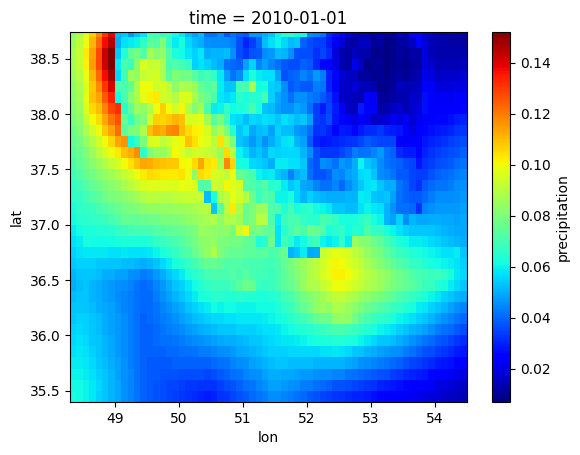

In [112]:
ds_xr['precipitation'].sel(time = '2010-01-01').plot(x = 'lon', y = 'lat', cmap = 'jet')

In [117]:
print(ds_xr.dims)

FrozenMappingWarningOnValuesAccess({'time': 295, 'lon': 620, 'lat': 334})


In [118]:
shapefile_path = "./assets/geo_data/Iran_1400/Ostan.shp"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")

if 'lon' in ds_xr.dims and 'lat' in ds_xr.dims:
    ds_xr = ds_xr.rename({'lon': 'x', 'lat': 'y'})

ds_xr = ds_xr.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds_xr.rio.write_crs("EPSG:4326", inplace=True)
ds_clipped = ds_xr.rio.clip(gdf.geometry, gdf.crs)

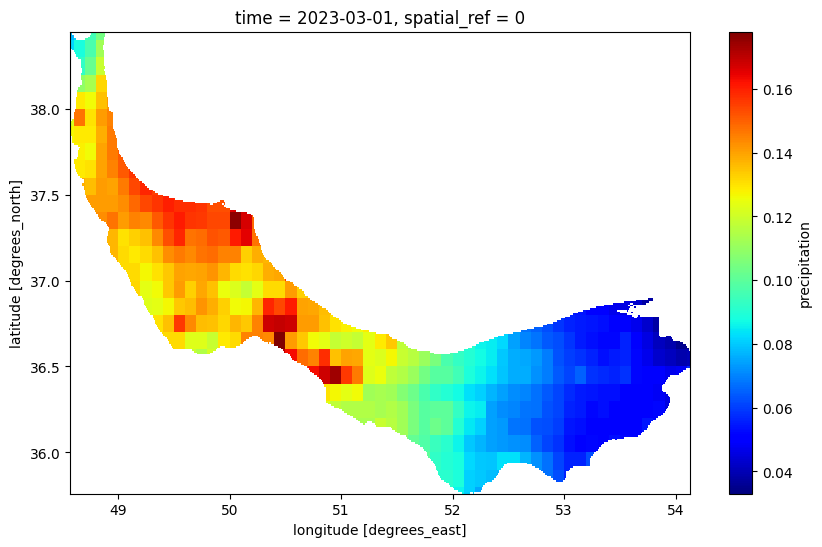

In [134]:
ds_clipped['precipitation'].sel(time = '2023-03-01').plot(x = 'x', y = 'y', cmap = 'jet', figsize = (10, 6))

In [136]:
def convert_mm_per_hr_to_mm(ds):
    # Extract the time index from the dataset
    time_index = ds['time'].values  # Assuming time is in datetime64 format
    
    # Compute number of hours in each month
    hours_in_month = np.array(
        [(pd.Timestamp(t).days_in_month * 24) for t in time_index]
    )
    
    # Expand dimensions to match the dataset shape
    hours_in_month = xr.DataArray(
        hours_in_month, dims=['time'], coords={'time': ds.time}
    )
    
    # Convert precipitation from mm/hr to mm
    ds['precipitation'] = ds['precipitation'] * hours_in_month
    
    return ds

In [137]:
ds_clipped_mm = convert_mm_per_hr_to_mm(ds_clipped)

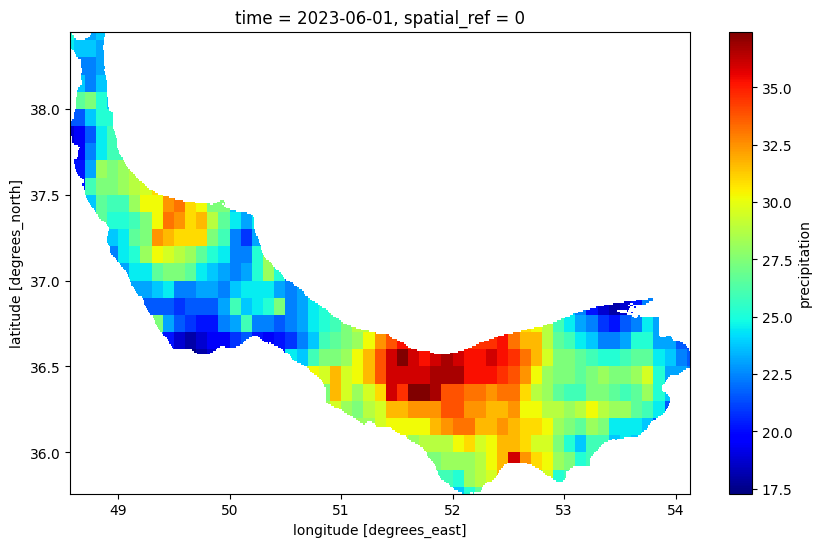

In [141]:
ds_clipped_mm['precipitation'].sel(time = '2023-06-01').plot(x = 'x', y = 'y', cmap = 'jet', figsize = (10, 6))